# Hands On ML Chapter 3 - Training Models

In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn import datasets

## Linear Regression

### The Normal Equation
The Normal Equation finds value of $ \theta $ that minimizes the cost function. (Lowest MSE value)

$ \theta = (X^T X)^{-1} X^T y $


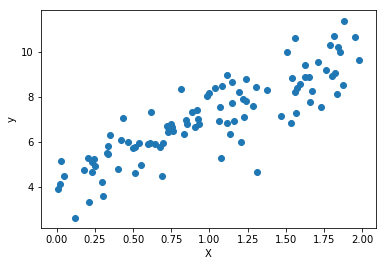

In [4]:
X = 2 * np.random.rand(100,1)
y= 4 + 3 * X + np.random.randn(100,1)
plt.scatter(X,y)
plt.xlabel("X")
plt.ylabel("y")

In [5]:
X_b = np.c_[np.ones((100,1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

The actual functon we made for generate data: y = 4 + 3x0 + Gaussian Noise

Results we got: y = 3.93 + 2.96x

In [6]:
theta_best

array([[ 4.23598205],
       [ 2.84330834]])

Lets predict some value:

In [7]:
X_new = np.array([[0], [2]]) #two predictions: x=0, x=2
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.23598205],
       [ 9.92259872]])

Plot predictions:

[0, 2, 0, 15]

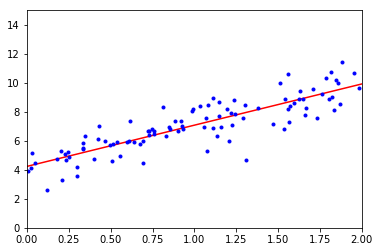

In [8]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X,y,"b.")
plt.axis([0,2,0,15])

The same with scikit-learn:

In [9]:
lin_reg = LinearRegression()
lin_reg.fit(X,y)
lin_reg.intercept_, lin_reg.coef_, lin_reg.predict(X_new)

(array([ 4.23598205]), array([[ 2.84330834]]), array([[ 4.23598205],
        [ 9.92259872]]))

## Gradient Descent

Gradient Descent - imagine you are in the mountains in the fog. You try to go down, so you check ground below your feet step by step. Then you decide in which direction you will go to get down. That is how it works. It does step by step to reach global minimum. 

Note: with using gradient descent all features should have a similiar scale - StabdardScaler

###  Batch Gradient Descent

Batch Gradient Descent involves full training set at each step. It is very slow on very large training sets.

In [10]:
eta = 0.1 # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
    
theta

array([[ 4.23598205],
       [ 2.84330834]])

### Stochastic Gradient Descent

Stochastic Gradient Descent is opposite to Batch GD. It picks random instance in the training dataset at each step and computes the gradients based only on that instance. It leads to being faster but also it makes algorith less regular. The final parameter is good but not optimal. It can be used for huge training sets.

In [11]:
n_epochs = 50
t0, t1 = 5, 50 # learning hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1) # random initialization

for epoch in range(n_epochs):
    for i in  range(m):
        if not (epoch==0 and i == 50):
            random_index = np.random.randint(m)
            xi = X_b[random_index:random_index-1]
            yi = y[random_index:random_index+1]
            gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
            eta = learning_schedule(epoch * m - i)
            #print(eta, epoch, i)
            theta = theta - eta * gradients
        
theta

array([[ 9.22305061],
       [-0.01376157]])

Implementation with scikit:

In [12]:
sgd_reg = SGDRegressor(n_iter = 50, penalty = None, eta0 = 0.1)
sgd_reg.fit(X,y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([ 4.23300287]), array([ 2.82360435]))

### Mini-batch Gradient Descent

Mix of two above. Takes small random sets of instances to compute gradients on them. Faster than Batch. Goes cloesely to the global minimum than SGD, but it can be harder to escape from local minimum.

## Polynomial Regression

Ndgree polynomial regressions - transform simple feature X, to array containing X, X squared etc.

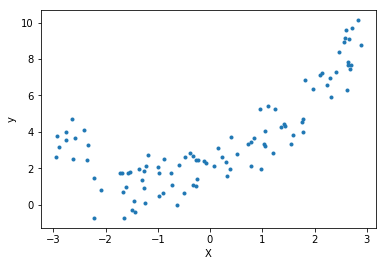

In [13]:
m = 100
X = 6 * np.random.rand(m, 1) - 3 # first degree of X
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1) # y uses first and second degree
plt.plot(X,y, ".")
plt.xlabel("X")
plt.ylabel("y")

In [14]:
poly_features = PolynomialFeatures(degree = 2, include_bias = False) # we need second degree of X
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([ 2.56862979]), array([ 2.56862979,  6.597859  ]))

In [15]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([ 1.90051124]), array([[ 1.06099002,  0.52615048]]))

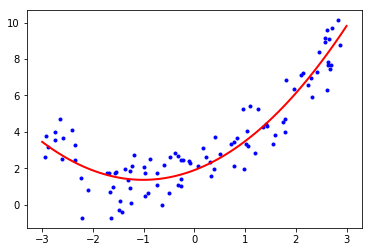

In [16]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")

## Learning Curves

Note: in chapter 2 it was said that: 
* when your model performs well on training set and poor on test set, model is overfitting
* when your model performs poor on both model is underfitting

Other way of check if model is over/underfitting is plot of Learning Curves

### Underfitting model example

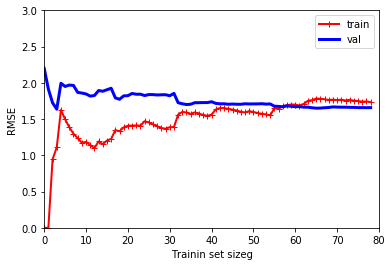

In [17]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right")
    plt.xlabel("Trainin set sizeg")
    plt.ylabel("RMSE")
    plt.axis([0, 80, 0, 3])
    
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

As we can see when training size is very small error is very small. It increases with increasing training set because model cannot fit noised larger model perfectly. But finally it reaches a plateau.

For the test size: if we have very small training set, we cannot predict well test instances so error is very big. With increasing training set we decrease value of error. It ends up very close to the other curve.

### Overfitting model example

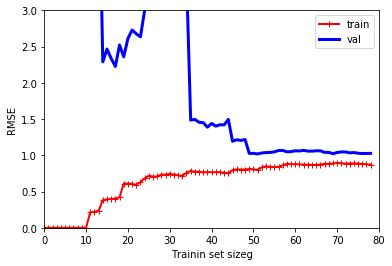

In [18]:
polynomial_regression = Pipeline((
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression())
))

plot_learning_curves(polynomial_regression, X, y)

The error on training set is much lower than with Linear Regression model

There is gap between two curves. Model works better for training set, that test set. It means that model is overfitting data.

## Regularized Linear Models

### Ridge Regression

We can use it for avoid overfitting data. Increasing alpha parameter decreases weights. Very large alpha parameter makes all weights to be very close to 0. Then result is flat line going through the data's mean.

In [19]:
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[ 5.18146731]])

In [20]:
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([ 4.37526453])

### Lasso Regression

LR reduces the useless features wieghts down to zero

In [21]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([ 5.13912413])

### Elastic Net

Mix of Ridge and Lasso Regression. When r=0, Elastic Net is equivalent to Ridge Regression, when r=1, it is equivalent to Lasso Regression.

In [28]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([ 5.13643362])

### Early Stopping

Different way to regularize. It stops training as soon as the validation error reaches minimum.

In [27]:
#sgd_reg = SGDRegressor(n_iter=1, warm_start=True, penalty=None, learning_rate="constant", eta0=0.0005)
#
#minimum_val_error = float("inf")
#best_epoch = None
#best_model = None
#
#for epoch in range(1000):
#    sgd_reg.fit(X_train_poly_scaled, y_train)
#    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
#    val_error = mean_squared_error(y_val_predict, y_val)
#    if val_error < minimum_val_error:
#        minimum_val_error = val_error
#        best_epoch = epoch
#        best_model = clone(sgd_reg)

## Logistic Regression

Some regression algorithms can be used for classification as well. Logistic Regression is used to estimate the probability that an instance belongs to class. It is binary classifier. If probability is higher than 50% it means that instance belongs to the class. 

### Iris dataset example

In [30]:
iris = datasets.load_iris()
list(iris.keys())

['DESCR', 'data', 'target_names', 'target', 'feature_names']

In [31]:
X = iris["data"][:, 3:] #petal width
y = (iris["target"] == 2).astype(np.int) # 1 if iris-virginica, else 0

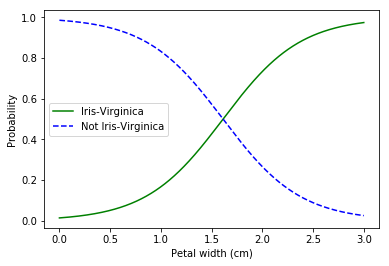

In [36]:
log_reg = LogisticRegression()
log_reg.fit(X,y)

X_new = np.linspace(0, 3, 1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0 ], "b--", label="Not Iris-Virginica")
plt.legend(loc="center left")
plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")

### Softmax Regression

The Logistic Regression model can be generalized to support multiple class. (not binary)

In [39]:
X = iris["data"][:, (2,3)] #petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X,y)

softmax_reg.predict([[5,2]]), softmax_reg.predict_proba([[5,2]])

(array([2]), array([[  6.33134076e-07,   5.75276067e-02,   9.42471760e-01]]))

94% of class2, 6% of class1